## Access Satellite Ghrsst L4 Gamssa 1Day Multi Sensor World data in Parquet
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l4_gamssa_1day_multi_sensor_world dataset available as a [Zarr](https://zarr.dev/)  dataset on S3

In [1]:
dataset_name = "satellite_ghrsst_l4_gamssa_1day_multi_sensor_world"

In [2]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [ ]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

In [3]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [8]:
from parquet_queries import plot_gridded_variable

In [11]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

KeyError: '.zmetadata'

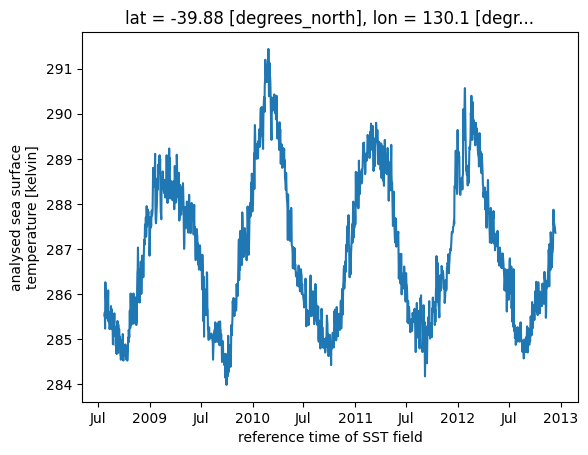

In [6]:
ds.analysed_sst.sel(lat=-40, lon=130, method='nearest').plot()

In [ ]:
plot_gridded_variable(ds, start_date='2022-06-01', lon_slice=(120, 150), lat_slice=(-50, -30), var_name='analysed_sst', n_days=6, coastline_resolution="50m")

In [ ]:
plot_gridded_variable(ds, start_date='2022-06-10', lon_slice=(4, 8), lat_slice=(-71, -69), var_name='sea_ice_fraction', n_days=9, coastline_resolution="10m")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

def daily_avg_sea_ice_fraction(ds, lon_slice, lat_slice, start_date=None, end_date=None, var_name='sea_ice_fraction'):
    """
    Computes and plots the daily average of sea_ice_fraction over a given region (lon_slice, lat_slice)
    for a specified time range, bounded by dataset limits if necessary.

    Parameters:
    - ds: xarray.Dataset containing the sea ice data.
    - lon_slice: tuple, longitude slice (start_lon, end_lon). (min val, max val)
    - lat_slice: tuple, latitude slice (start_lat, end_lat). (min val, max val)
    - start_date: str, start date in 'YYYY-MM-DD' format (optional).
    - end_date: str, end date in 'YYYY-MM-DD' format (optional).
    - var_name: str, variable name to calculate the average for (default is 'sea_ice_fraction').

    Returns:
    - xarray.Dataset containing the daily average of sea_ice_fraction for the specified region and time period.
    """

    # Decide on the slice order
    if ds.lat[0] < ds.lat[-1]:
        lat_slice = lat_slice
    elif ds.lat[0] > ds.lat[-1]:  
        lat_slice = lat_slice[::-1]

    # Ensure the dataset has a time dimension
    assert 'time' in ds.dims, "Dataset does not have a 'time' dimension"

    # Determine the dataset's time range
    dataset_start = pd.to_datetime(ds.time.min().values)
    dataset_end = pd.to_datetime(ds.time.max().values)

    # Parse the start and end dates, default to dataset limits if necessary
    start_date = pd.to_datetime(start_date) if start_date else dataset_start
    end_date = pd.to_datetime(end_date) if end_date else dataset_end

    # Bound the start and end dates within the dataset's time range
    if start_date < dataset_start:
        start_date = dataset_start
    if end_date > dataset_end:
        end_date = dataset_end

    # Select the time range and area
    selected_data = ds.sel(
        lon=slice(lon_slice[0], lon_slice[1]),
        lat=slice(lat_slice[0], lat_slice[1]),
        time=slice(start_date, end_date)
    )

    # Compute the boolean masks for quality level and flags on the selected data
    #quality_mask = (selected_data['quality_level'] >= 4).compute()
    flags_mask = (selected_data['mask'] >= 2).compute()

    # Apply masks to filter the dataset
    filtered_ds = selected_data.where( flags_mask, drop=True)
    #filtered_ds = selected_data
    # Calculate the daily average over the filtered area
    daily_avg = filtered_ds[var_name].mean(dim=['lon', 'lat']).resample(time='1D').mean()

    # Calculate percentage of non-NaN values
    valid_data_count = filtered_ds[var_name].count(dim=['lon', 'lat']).resample(time='1D').sum()
    total_data_count = selected_data[var_name].count(dim=['lon', 'lat']).resample(time='1D').sum()
    percentage_valid = (valid_data_count / total_data_count) * 100

    # Plot the time series of daily average sea_ice_fraction
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot daily average sea ice fraction
    daily_avg.plot(ax=ax1, color='blue', marker='o', linestyle='-', label='Daily Avg Sea Ice Fraction')
    ax1.set_ylabel(f"{ds[var_name].attrs.get('units', 'unitless')} (%)")
    ax1.set_title(f"Daily Average {ds[var_name].attrs.get('long_name', var_name)} ({start_date.date()} to {end_date.date()})")
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    ax1.grid(True)

    # Create a second y-axis to plot percentage of valid data
    ax2 = ax1.twinx()
    percentage_valid.plot(ax=ax2, color='orange', marker='x', linestyle='-', label='Percentage of Measured Data Points in Grid')
    ax2.set_ylabel("Percentage of Measured Data Points in Grid (%)")
    ax2.set_ylim(0, 100)  # Set limits for the percentage axis

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.show()

    # Return the daily average as an xarray.Dataset
    return daily_avg.to_dataset(name=f'daily_avg_{var_name}')


In [ ]:
ds = ds.sortby('time')
result_ds = daily_avg_sea_ice_fraction(ds, lon_slice=(5, 7), lat_slice=(-71, -69), start_date='2022-01-26',  end_date='2022-02-20', var_name='sea_ice_fraction')